# Data preprocessing and trajectory analysis

In [1]:
library(data.table) # Fread
library(dplyr)
library(geosphere) # Calculate vehicle distance
library(lubridate)# Date column extraction
library(robfilter)# Smooth the data
library(ggplot2) # Plot
library(ggpubr) # Combine different plots
library(ggmap) # plot points on the map

Warning message:
"package 'data.table' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'geosphere' was built under R version 3.6.3"

Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from 'package:base':

    date


Warning message:
"package 'robfilter' was built under R version 3.6.3"
Loading required package: robustbase

Warning message:
"package 'robustbase' was built under R version 3.6.3"
Loading required package: MASS

Warning message:
"package 'MASS' was built 

In [92]:
library(RColorBrewer)

In [2]:
# adjust the R limit
memory.limit(size=249200)

[1] 249200

## Input location data

In [2]:
# Read data from folder
# Suggestion: Just do one year at one time. One year's table has 94363502 rows(green)
YEARLIST = c('19')
MONTHlIST = c("04") # FOR FULL TABLE
DISTANCE_FILEPATH = "../../data/raw/vehicle-location/"

In [3]:
# Add different time scale columns
add_dd_mm_yy_cols = function(df) {
    df$day = day(df$trxtime)
    df$month = month(df$trxtime)
    df$year = year(df$trxtime)
    return(df)
}
# Read light rail location raw data
get_light_rail_trajectories = function(year, month){
    assign("dg", fread(paste(DISTANCE_FILEPATH, paste("lightrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    dg = add_dd_mm_yy_cols(dg)
    return(dg)
}
# Read heavy rail location raw data
get_heavy_rail_trajectories = function(year, month){
    assign("dh", fread(paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    dh = add_dd_mm_yy_cols(dh)
    return(dh)
}

In [4]:
# Get the raw table
df_lightrail = get_light_rail_trajectories(YEARLIST,MONTHlIST)
df_heavyrail = get_heavy_rail_trajectories(YEARLIST,MONTHlIST)

In [200]:
# Subset table by a given day
get_day_trajectories = function(df, dayid){
    day_df = df[day == dayid, .SD, keyby = .(trainid, vehicleid, routeid) ]
    print(paste("Number of observations", nrow(day_df), "on day", dayid ))
    return(day_df)
}
# Create trajectory index table 
get_unique_trajectory_indices = function(day_df) {
    trajectory_index_df = unique(day_df[, .(trainid, vehicleid, routeid, car1, car2, car3)])
    print(paste("Number of unique trajectories extracted: ", dim(trajectory_index_df)[1]))
    return(trajectory_index_df)
}

# Subset the raw table by unique index
extract_unique_trajectory = function(day_df, traj_index_df, index){
    day_df[["car2"]][is.na(day_df[["car2"]])] <- 9999999
    day_df[["car3"]][is.na(day_df[["car3"]])] <- 9999999
    traj_index_df[["car2"]][is.na(traj_index_df[["car2"]])] <- 9999999
    traj_index_df[["car3"]][is.na(traj_index_df[["car3"]])] <- 9999999
    trajectory = day_df[trainid == traj_index_df[index, 1][[1]] & 
                        vehicleid == traj_index_df[index, 2][[1]] &
                        routeid == traj_index_df[index, 3][[1]] &
                        car1 == traj_index_df[index, 4][[1]] &
                        car2 == traj_index_df[index, 5][[1]] &
                        car3 == traj_index_df[index, 6][[1]],][order(trxtime)]
    clean_trajectory = trajectory[, .SD[1], by = trxtime] # takes first observation of multiple with same time
    clean_trajectory[["car2"]][clean_trajectory[["car2"]] == 9999999] = NA
    clean_trajectory[["car3"]][clean_trajectory[["car3"]] == 9999999] = NA
    # transfer trxtime to timestamp
    options(tz = "America/New_York")
    clean_trajectory$time = as.POSIXct(clean_trajectory$trxtime,tz = getOption("tz"))
    return (clean_trajectory)
}

In [201]:
# generate the specified trajectory table
light_subset = function(df,day,index){
    day_df = get_day_trajectories(df, day)
    trajectory_index_df = get_unique_trajectory_indices(day_df)
    clean_trajectory_df = extract_unique_trajectory(day_df, trajectory_index_df, index)
    return(list(clean_trajectory = clean_trajectory_df , index = trajectory_index_df))
}

In [137]:
df_test = light_subset(df_lightrail,1,3)$clean_trajectory

[1] "Number of observations 313823 on day 1"
[1] "Number of unique trajectories extracted:  1208"


In [139]:
day_1_index = light_subset(df_lightrail,1,3)$index
day_2_index = light_subset(df_lightrail,2,3)$index

[1] "Number of observations 313823 on day 1"
[1] "Number of unique trajectories extracted:  1208"
[1] "Number of observations 259529 on day 2"
[1] "Number of unique trajectories extracted:  1438"


In [260]:
day_1_index[car1 > 9000]

trainid,vehicleid,routeid,car1,car2,car3
<int>,<chr>,<int>,<int>,<int>,<int>
10056,9999,813,9999,NA,NA
10092,9999,0,9999,NA,NA
10131,9999,813,9999,NA,NA
10150,9999,0,9999,NA,NA
10154,9999,0,9999,NA,NA
10175,9999,813,9999,NA,NA
10190,9999,0,9999,NA,NA
10192,9999,0,9999,NA,NA
10202,9999,813,9999,NA,NA


In [257]:
day_1_index_melt = melt(day_1_index, id.vars = "trainid", measure.vars = c("car1","car2"))

In [258]:
day_1_index_melt = day_1_index_melt %>% distinct(trainid, value, .keep_all = TRUE)

In [259]:
day_1_index_melt[value > 9000]

trainid,variable,value
<int>,<fct>,<int>
10056,car1,9999
10092,car1,9999
10131,car1,9999
10150,car1,9999
10154,car1,9999
10175,car1,9999
10190,car1,9999
10192,car1,9999
10202,car1,9999


Warning message:
"Removed 162 rows containing missing values (geom_point)."


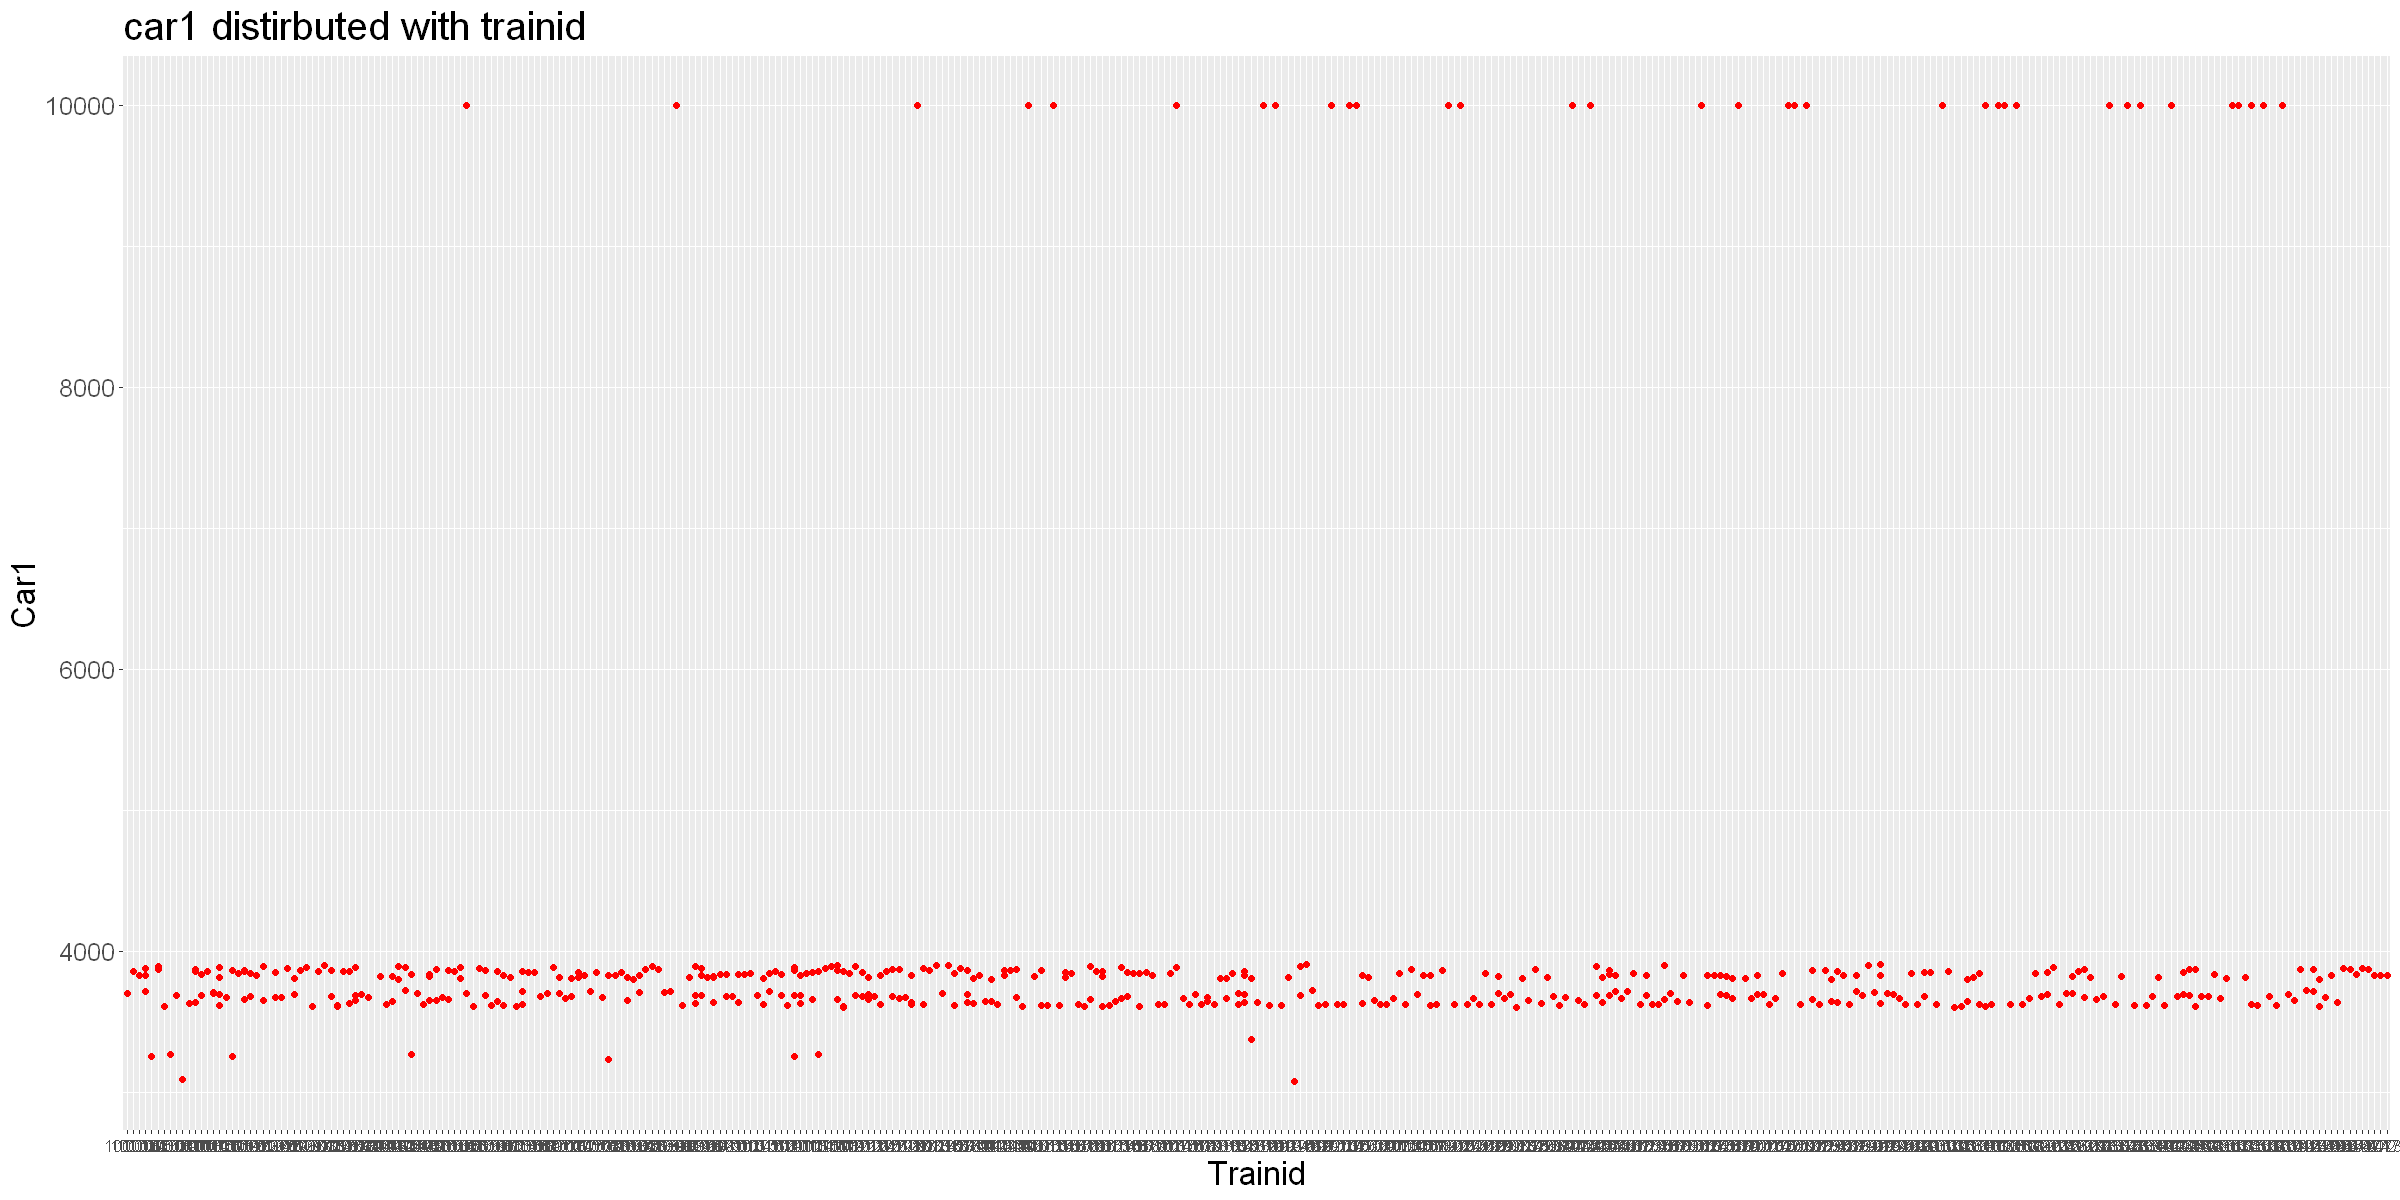

In [171]:
ggplot(day_1_index_melt,aes(x = factor(trainid),y = value)) + 
    geom_point(color="red") +  
    labs(title = "car1 distirbuted with trainid", x= "Trainid", y= "Car1")+
    theme( title= element_text(size = 20),
          axis.text.x = element_text(size = 10),
          axis.text.y = element_text(size = 15))

In [202]:
df_test_2 = light_subset(df_lightrail,2,7)$clean_trajectory
df_test_3 = light_subset(df_lightrail,2,8)$clean_trajectory

[1] "Number of observations 259529 on day 2"
[1] "Number of unique trajectories extracted:  1438"
[1] "Number of observations 259529 on day 2"
[1] "Number of unique trajectories extracted:  1438"


In [203]:
df_test_2

trxtime,trainid,vehicleid,routeid,counter,lineid,lat,lon,servicetypeid,sourceid,...,car3,speed,heading,rcvtime,lastavi,inserted,day,month,year,time
<chr>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dttm>
2019-04-02 08:11:49,10004,3600,852,62364,4,42.33596,-71.24962,1,1,...,NA,28.11,123.68,2019-04-02 08:11:50,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:11:49
2019-04-02 08:11:55,10004,3600,852,62386,4,42.33567,-71.24901,1,1,...,NA,32.56,123.76,2019-04-02 08:11:55,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:11:55
2019-04-02 08:11:57,10004,3600,852,62393,4,42.33535,-71.24840,1,1,...,NA,33.19,123.92,2019-04-02 08:11:58,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:11:57
2019-04-02 08:12:01,10004,3600,852,62406,4,42.33506,-71.24777,1,1,...,NA,33.50,124.01,2019-04-02 08:12:01,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:12:01
2019-04-02 08:12:07,10004,3600,852,62426,4,42.33475,-71.24716,1,1,...,NA,33.55,123.87,2019-04-02 08:12:07,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:12:07
2019-04-02 08:12:13,10004,3600,852,62455,4,42.33411,-71.24592,1,1,...,NA,33.87,124.25,2019-04-02 08:12:13,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:12:13
2019-04-02 08:12:15,10004,3600,852,62469,4,42.33382,-71.24534,1,1,...,NA,33.35,123.37,2019-04-02 08:12:15,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:12:15
2019-04-02 08:12:19,10004,3600,852,62499,4,42.33348,-71.24470,1,1,...,NA,27.92,124.43,2019-04-02 08:12:19,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:12:19
2019-04-02 08:12:25,10004,3600,852,62530,4,42.33322,-71.24409,1,1,...,NA,13.65,123.85,2019-04-02 08:12:25,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:12:25


In [192]:
df_test_combine_test = case_1(df_test_combine)

[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 852|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"
[2] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 892|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"
[3] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 853|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 5 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
file saved to ../../figures/case1_combine.png



NULL


In [179]:
df_test_combine = light_subset(df_lightrail,2,7)$clean_trajectory

[1] "Number of observations 259529 on day 2"
[1] "Number of unique trajectories extracted:  1438"


In [ ]:
compute_day_trajectories = function(month_df, dd) {
    df_dd = get_day_trajectories(month_df, dd)
    traj_indices_dd = get_unique_trajectory_indices(df_dd)
    print(head(traj_indices_dd))
    num_traj = nrow(traj_indices_dd)
    for (tt in seq(num_traj)[1:5] ) { # ideally this should be for the whole sequence
        traj = extract_unique_trajectory(df_dd, traj_indices_dd, tt)
        traj$trajid = tt # add a new column
        traj %<>% preprocess_data() %>% compute_distance() %>% compute_speed_acceleration() 
        if (tt==1) {
            processed_traj_df = traj
        } else {
            processed_traj_df = rbind(processed_traj_df, traj)
        }
    }
    return (processed_traj_df)
}


In [185]:
case_1 = function(clean_trajectory){
    clean_trajectory = compute_time_interval(clean_trajectory)
    clean_trajectory = compute_distance(clean_trajectory)
    clean_trajectory = compute_speed_acceleration(clean_trajectory)
    clean_trajectory = compute_cumulative_time_distance(clean_trajectory)
    trajectory_plot(clean_trajectory)
    return(clean_trajectory)
    }

In [184]:
case_2 = function(clean_trajectory,w){
     clean_trajectory = compute_time_interval(clean_trajectory)
     clean_trajectory = compute_distance(clean_trajectory) 
     filter = robreg.filter(clean_trajectory$dist_meters, width = w, online = FALSE, method= "MED")
     clean_trajectory$dist_meters = filter$level$MED
     clean_trajectory = compute_speed_acceleration(clean_trajectory)
     clean_trajectory = compute_cumulative_time_distance(clean_trajectory)
     trajectory_plot(clean_trajectory)
     return(clean_trajectory)
}

In [183]:
case_3 = function(clean_trajectory){
    clean_trajectory = data.table(clean_trajectory)
    clean_trajectory = compute_time_interval(clean_trajectory)
    clean_trajectory = clean_trajectory[interval_seconds > 1]
    clean_trajectory = compute_time_interval(clean_trajectory)
    clean_trajectory = compute_distance(clean_trajectory)
    clean_trajectory = compute_speed_acceleration(clean_trajectory)
    clean_trajectory = compute_cumulative_time_distance(clean_trajectory)
    trajectory_plot(clean_trajectory)
    return(clean_trajectory)
    
}

In [182]:
case_4 = function(clean_trajectory,w){
    clean_trajectory = data.table(clean_trajectory)
    clean_trajectory = compute_time_interval(clean_trajectory)
    clean_trajectory = clean_trajectory[interval_seconds > 1]
    clean_trajectory = compute_time_interval(clean_trajectory)
    clean_trajectory = compute_distance(clean_trajectory)
    filter = robreg.filter(clean_trajectory$dist_meters, width = w, online = FALSE, method= "MED")
    clean_trajectory$dist_meters = filter$level$MED
    clean_trajectory = compute_speed_acceleration(clean_trajectory)
    clean_trajectory = compute_cumulative_time_distance(clean_trajectory)
    trajectory_plot(clean_trajectory)
    return(clean_trajectory)
}

In [199]:
df_test_combine_test = case_4(df_test_combine,10)

1 out of 1240 time series values in clean_trajectory$dist_meters are missing. 
[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 852|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"
[2] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 892|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"
[3] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 853|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
file saved to ../../figures/case4_combine.png



NULL


In [211]:
df_test_2_case1 = case_1(df_test_2)

[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 852|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 5 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
file saved to ../../figures/case1_t2.png



NULL


In [240]:
df_test_3_case1 = case_1(df_test_3)

[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 853|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 5 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
file saved to ../../figures/case1_t3.png



NULL


In [213]:
df_test_2_case2_5 = case_2(df_test_2,5)

1 out of 1049 time series values in clean_trajectory$dist_meters are missing. 
[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 852|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 11 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 3 rows containing missing values (geom_text)."
Warning message:
"Removed 11 rows containing missing values (geom_point)."
file saved to ../../figures/case2_t2_5.png



NULL


In [243]:
df_test_3_case2_5 = case_2(df_test_3,5)

1 out of 221 time series values in clean_trajectory$dist_meters are missing. 
[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 853|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 11 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 3 rows containing missing values (geom_text)."
Warning message:
"Removed 11 rows containing missing values (geom_point)."
file saved to ../../figures/case2_t3_5.png



NULL


In [215]:
df_test_2_case2_7 = case_2(df_test_2,7)

1 out of 1049 time series values in clean_trajectory$dist_meters are missing. 
[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 852|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
file saved to ../../figures/case2_t2_7.png



NULL


In [245]:
df_test_3_case2_7 = case_2(df_test_3,7)

1 out of 221 time series values in clean_trajectory$dist_meters are missing. 
[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 853|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
file saved to ../../figures/case2_t3_7.png



NULL


In [217]:
df_test_2_case2_9 = case_2(df_test_2,9)

1 out of 1049 time series values in clean_trajectory$dist_meters are missing. 
[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 852|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
file saved to ../../figures/case2_t2_9.png



NULL


In [248]:
df_test_3_case2_9 = case_2(df_test_3,9)

1 out of 221 time series values in clean_trajectory$dist_meters are missing. 
[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 853|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
file saved to ../../figures/case2_t3_9.png



NULL


In [219]:
df_test_2_case3 = case_3(df_test_2)

[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 852|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 5 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
file saved to ../../figures/case3_t2.png



NULL


In [251]:
df_test_3_case3 = case_3(df_test_3)

[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 853|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 5 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
file saved to ../../figures/case3_t3.png



NULL


In [221]:
df_test_2_case4_5 = case_4(df_test_2,5)

1 out of 1018 time series values in clean_trajectory$dist_meters are missing. 
[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 852|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 11 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 3 rows containing missing values (geom_text)."
Warning message:
"Removed 11 rows containing missing values (geom_point)."
file saved to ../../figures/case4_t2_5.png



NULL


In [253]:
df_test_3_case4_9 = case_4(df_test_3,9)

1 out of 202 time series values in clean_trajectory$dist_meters are missing. 
[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 853|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
file saved to ../../figures/case4_t3_9.png



NULL


In [223]:
df_test_2_case4_7 = case_4(df_test_2,7)

1 out of 1018 time series values in clean_trajectory$dist_meters are missing. 
[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 852|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
file saved to ../../figures/case4_t2_7.png



NULL


1 out of 1018 time series values in clean_trajectory$dist_meters are missing. 
[1] "Line: Green|Trainid: 10004|Vehicleid:   3600|Routeid: 852|Car1: 3600|Car2: 3855|Car3: NA|Date: 4-2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."


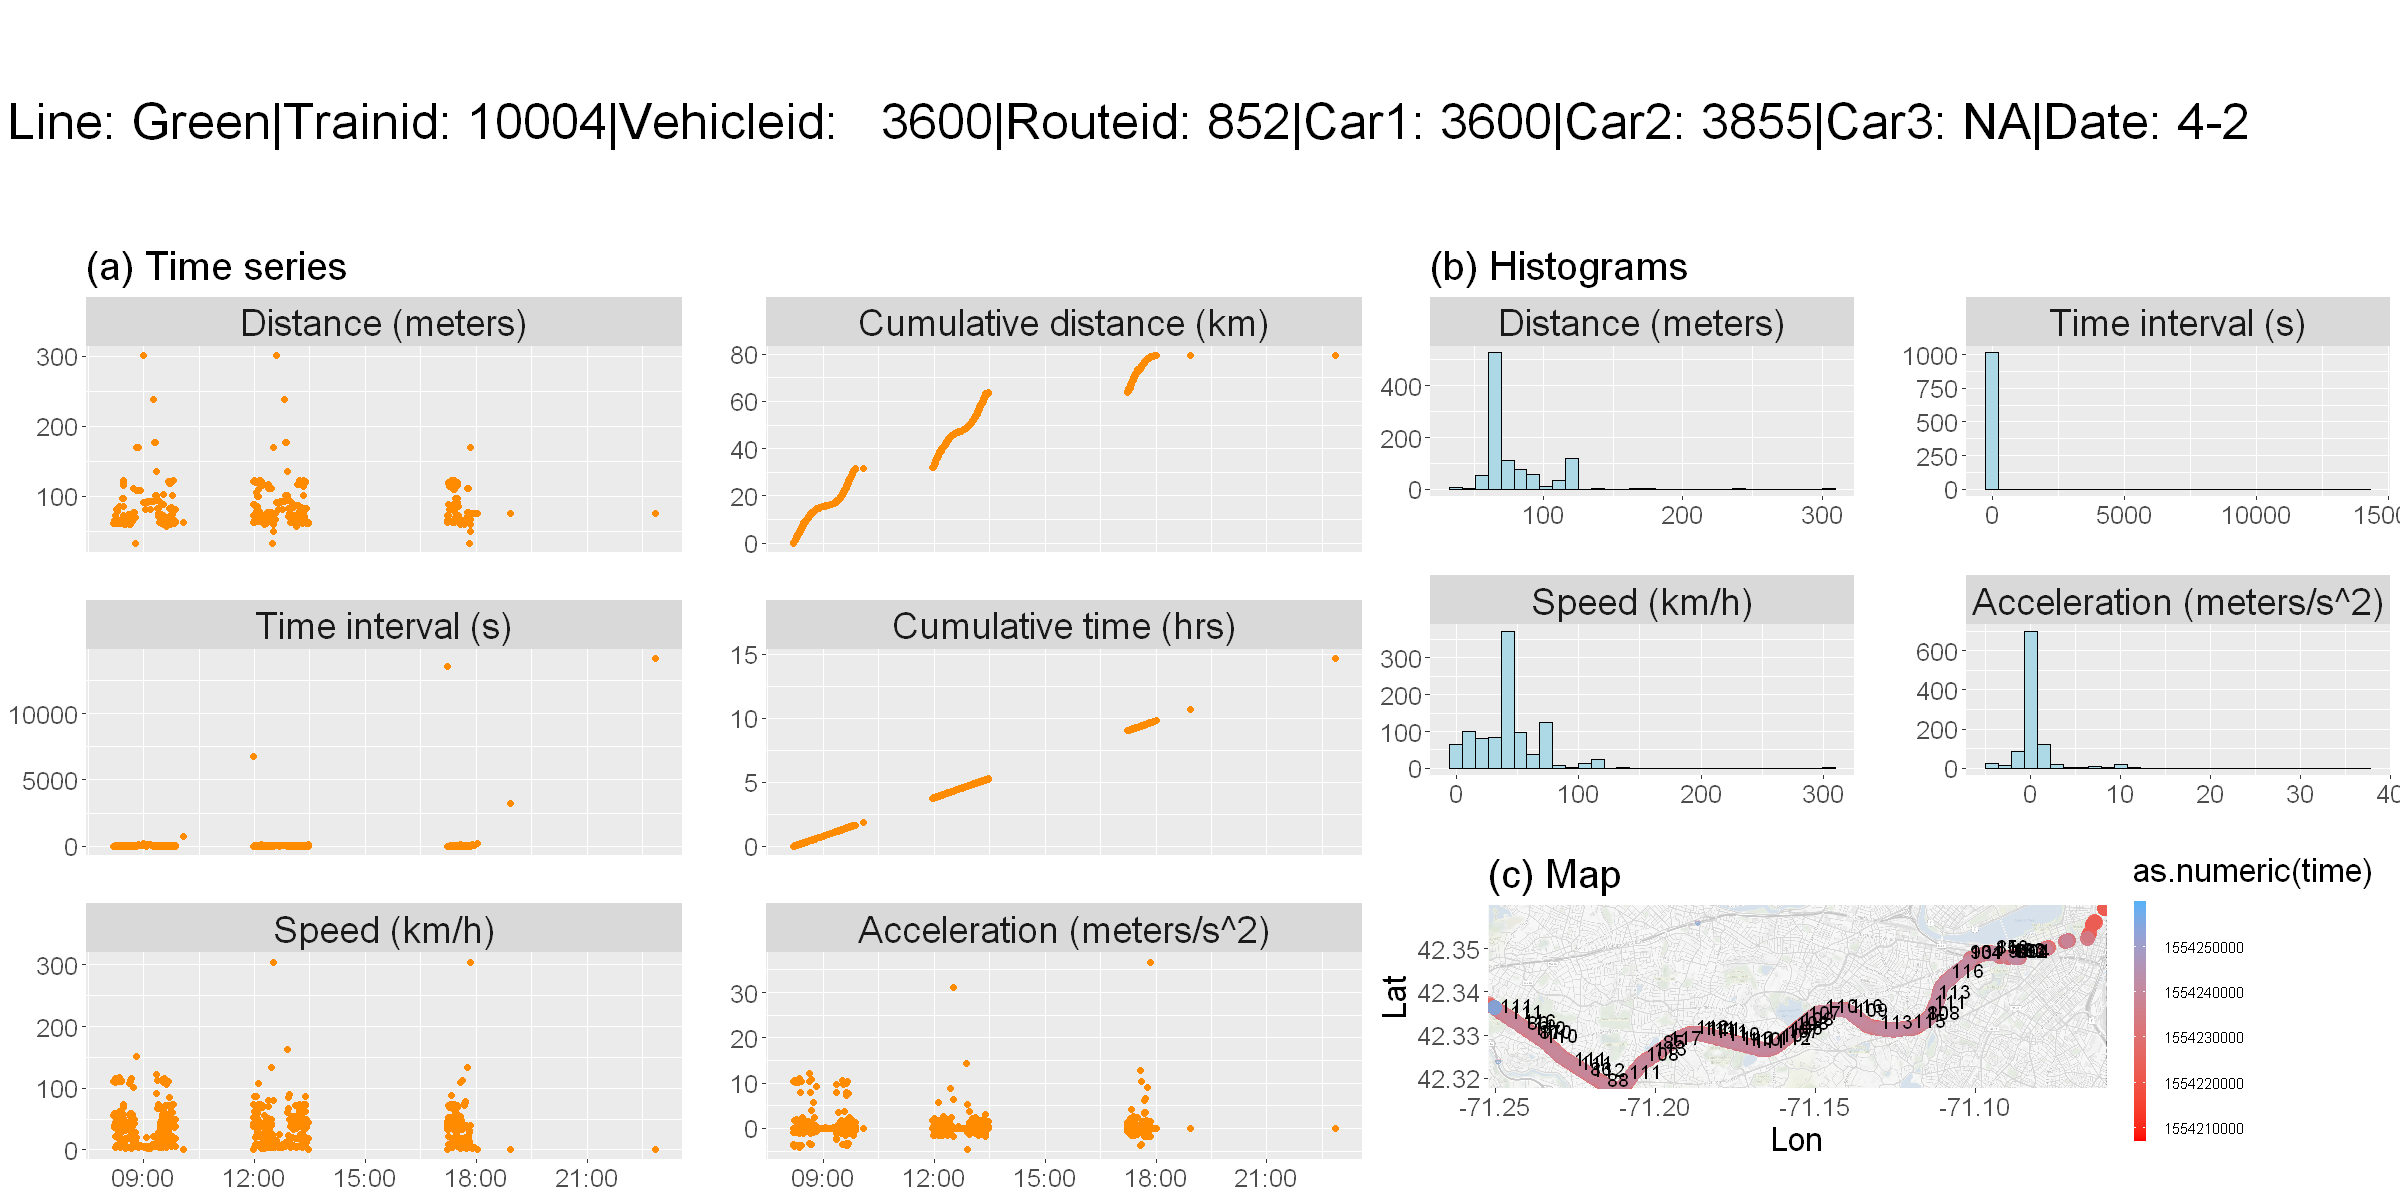

In [263]:
df_test_2_case4_9 = case_4(df_test_2,9)

In [256]:
d_compare_table

case,speed_median,speed_max,speed_min,speed_mean,acceleration_median,acceleration_max,acceleration_min,acceleration_mean,total_distance_km,total_time_hrs
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
case 1,37.36654,422.3174,0.00000000,47.58175,-0.01554562,59.80630,-16.344459,1.3006314,109.41533,14.64861
case 2_5,38.18810,241.2729,0.01648218,47.74319,0.00000000,59.11999,-14.491184,1.5380895,87.07368,14.64861
case 2_7,38.30656,235.8708,0.01648218,47.28620,0.00000000,59.33268,-13.290289,1.5650001,83.26809,14.64861
case 2_9,38.30656,304.3673,0.01627265,46.44050,0.00000000,59.40180,-12.491960,1.5957672,79.26394,14.64861
case 3,37.34928,422.3174,0.00000000,44.22595,-0.01540451,19.66380,-16.344459,0.3249097,109.35378,14.64694
case 4_5,38.07821,212.3691,0.01667746,43.76150,0.00000000,19.00000,-6.052150,0.4119195,87.02196,14.64694
case 4_7,38.30656,202.9115,0.01667746,43.11811,0.00000000,17.61543,-11.434340,0.3946086,83.35011,14.64694
case 4_9,38.30656,304.3673,0.01664415,42.33313,0.00000000,36.69063,-4.738325,0.4519120,79.49378,14.64694


In [255]:
d_compare_table = compare_table(df_test_2_case1,df_test_2_case2_5,df_test_2_case2_7,df_test_2_case2_9,df_test_2_case3,df_test_2_case4_5,df_test_2_case4_7,df_test_2_case4_9)

# Function used for trajectory investigation

In [262]:
# plot each trajectory
trajectory_plot = function(df){
    p_title = title(df)
    # plot histogram for speed and acceleration
    clean_hist = melt(df, id.vars = c("time","month","day") ,
                                 measure.vars = c("dist_meters","interval_seconds",
                                                  "speed_kph","accel_mps2"))
    # Name new labels for hist plot
    levels(clean_hist$variable) = c("Distance (meters)", "Time interval (s)",
                                     "Speed (km/h)","Acceleration (meters/s^2)")
    # geom_jitter()
    p_hist = ggplot(clean_hist,aes(x = value)) + 
    geom_histogram(color="black", fill="lightblue") +  
    facet_wrap(~variable,ncol = 2 , scales = "free") +
    labs(title = "(b) Histograms") +
    theme(strip.text = element_text(size = rel(2)),
          # title
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          title= element_text(size = 20),
          # axis label
          axis.text.x = element_text(size = 15),
          axis.text.y = element_text(size = 15)，
          # space between facet plot
           panel.spacing = unit(2, "lines"))
    # plot time series
    clean_trajectory_melt = melt(df, id.vars = c("time","month","day") ,
                                 measure.vars = c("dist_meters","cumdist_km","interval_seconds",
                                                  "cumtime_hrs","speed_kph","accel_mps2"))
    # Name new labels for facet plot
    levels(clean_trajectory_melt$variable) = c("Distance (meters)","Cumulative distance (km)",
                                               "Time interval (s)","Cumulative time (hrs)","Speed (km/h)",
                                               "Acceleration (meters/s^2)")
    # generate the facet plot
    p_main = ggplot(clean_trajectory_melt,aes(x = time,y = value)) + 
    geom_point(colour="darkorange") + 
    facet_wrap(~variable,ncol = 2 , scales = "free_y") +
    labs(title = "(a) Time series ", x = "Time") +
    theme(strip.text = element_text(size = rel(2)),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          title= element_text(size = 20),
          axis.text.x = element_text(size = 15),
          axis.text.y = element_text(size = 15)，
          panel.spacing = unit(2, "lines"))
    # Trajectory map
    # Get map
    ma <- get_stamenmap(bbox = c(left = min(df$lon), bottom = min(df$lat), 
                                  right = max(df$lon), top = max(df$lat)), 
                         zoom = 14)
   # plotting trajectory map
    p_map = ggmap(ma , darken = c(0.6, "white")) +
    geom_point(data = df, aes(x = lon, y = lat, color = as.numeric(time), alpha = 0.7), size = 4, shape = 16) +
    geom_text(data = df, aes(label = ifelse(speed_kph > 80,round(speed_kph,0),'')),hjust=0,vjust=0,size = 4) +
    scale_color_gradient(low="red") + 
    labs(title = "(c) Map", x = "Lon", y = "Lat") +
    theme(axis.title.x = element_text(size = 20),
          axis.title.y = element_text(size = 20),
          title= element_text(size = 20)，
          axis.text.x = element_text(size = 15),
          axis.text.y = element_text(size = 15)) +
    guides(color = guide_colourbar(barwidth = 0.5, barheight = 10), alpha=FALSE, size=FALSE)
    p1 = ggarrange(p_hist, p_map, nrow = 2, ncol = 1,heights = c(15,10)) 
    # plot for ggarrange
    tgrob <- text_grob(p_title,size = 30)
    plot_0 <- as_ggplot(tgrob) + theme(plot.margin = margin(0,3,0,0, "cm"))
#    plot_name = paste("../../figures/",p_title,".png")
    options(repr.plot.width = 20, repr.plot.height = 10)
    p_plot = ggarrange(p_main, p1, nrow = 1, ncol = 2, widths = c(20,15)) 
    p = ggarrange(plot_0,p_plot,nrow = 2, ncol = 1,heights = c(5,20)) 
    #%>%
    # ggexport(filename = "../../figures/case4_t3_9.png",width = 1500, height = 1000)
#  uncomment the above line for saving plot as png locally
    print(p)
    return(p)
}

In [ ]:
# compute time interval
compute_time_interval <- function(d) {
    d$interval_seconds = NA
    n <- nrow(d)
    if (n >= 2) {
        # Compute time interval
        d$interval_seconds[2:n] = as.numeric(difftime(d$trxtime[2:n], d$trxtime[1:n-1], units = "secs"))
        }
    return(d)
}

In [13]:
# compute vehicle distance
compute_distance <- function(d) {
    d$dist_meters = NA
     n <- nrow(d)
    if (n >= 2) {
        # Compute interval distance using Haversine function
        d$dist_meters[2:n] = distHaversine(cbind(d$lon[1:n-1],d$lat[1:n-1]),cbind(d$lon[2:n],d$lat[2:n]))
        }
    return(d)
}

In [14]:
# compute speed and acceleration
compute_speed_acceleration <- function(d) {
    d$speed_mps = NA
    d$speed_kph = NA
    d$accel_mps2 = NA
    n <- nrow(d)
    if (n >= 2) {
        d$speed_mps[2:n] = d$dist_meters[2:n] / d$interval_seconds[2:n]
        # Convert speed to kph
        d$speed_kph[2:n] = d$speed_mps[2:n] * 3.6
        d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        }
    return(d)
}  

In [15]:
# Calculate the cumulative dist and time
compute_cumulative_time_distance = function(d){
    df = d
    # no rm.na argument in cumsum function,so we make distance and time with NA as 0
    df[is.na(df)] <- 0
    # Calculate the cumulative dist and time
    df = df %>%
    mutate(cumdist = cumsum(dist_meters)) %>%
    mutate(cumtime = cumsum(interval_seconds))
    d$cumdist_km = df$cumdist/1000
    d$cumtime_hrs = df$cumtime/3600
    return(d)
}

In [129]:
# Add title for each trajectory plot
title = function (clean_trajectory){
    linetype = paste("Line:","Green")
    trainid = paste("Trainid:",unique(clean_trajectory$trainid))
    vehicleid = paste("Vehicleid:",unique(clean_trajectory$vehicleid))
    routeid = paste("Routeid:",unique(clean_trajectory$routeid))
    car1 = paste("Car1:",unique(clean_trajectory$car1))
    car2 = paste("Car2:",unique(clean_trajectory$car2))
    car3 = paste("Car3:",unique(clean_trajectory$car3))
    month = unique(clean_trajectory$month)
    day = unique(clean_trajectory$day)
    date = paste("Date:",paste(month , day , sep = "-" ))
    df_title = paste(linetype,trainid,vehicleid, routeid , car1, car2 , car3 , date,sep = "|")
    print(df_title)
    return(df_title)
}

In [235]:
comparison_table[,2:11] = round(comparison_table[,2:11],2)

In [254]:
compare_table = function(case_1_test,case_2_test_5,case_2_test_7,case_2_test_9,case_3_test,case_4_test_5,case_4_test_7,case_4_test_9){
comparison_table = data.frame(case = c("case 1","case 2_5","case 2_7","case 2_9","case 3","case 4_5","case 4_7","case 4_9"),
                              speed_median = c(median(case_1_test$speed_kph,na.rm = TRUE),
                                               median(case_2_test_5$speed_kph,na.rm = TRUE),
                                               median(case_2_test_7$speed_kph,na.rm = TRUE),
                                               median(case_2_test_9$speed_kph,na.rm = TRUE),
                                               median(case_3_test$speed_kph,na.rm = TRUE),
                                               median(case_4_test_5$speed_kph,na.rm = TRUE),
                                               median(case_4_test_7$speed_kph,na.rm = TRUE),
                                               median(case_4_test_9$speed_kph,na.rm = TRUE)) ,
                              speed_max = c(max(case_1_test$speed_kph,na.rm = TRUE),
                                               max(case_2_test_5$speed_kph,na.rm = TRUE),
                                               max(case_2_test_7$speed_kph,na.rm = TRUE),
                                               max(case_2_test_9$speed_kph,na.rm = TRUE),
                                               max(case_3_test$speed_kph,na.rm = TRUE),
                                               max(case_4_test_5$speed_kph,na.rm = TRUE),
                                               max(case_4_test_7$speed_kph,na.rm = TRUE),
                                               max(case_4_test_9$speed_kph,na.rm = TRUE)) ,
                              speed_min = c(min(case_1_test$speed_kph,na.rm = TRUE),
                                               min(case_2_test_5$speed_kph,na.rm = TRUE),
                                               min(case_2_test_7$speed_kph,na.rm = TRUE),
                                               min(case_2_test_9$speed_kph,na.rm = TRUE),
                                               min(case_3_test$speed_kph,na.rm = TRUE),
                                               min(case_4_test_5$speed_kph,na.rm = TRUE),
                                               min(case_4_test_7$speed_kph,na.rm = TRUE),
                                               min(case_4_test_9$speed_kph,na.rm = TRUE)) ,
                              speed_mean = c(mean(case_1_test$speed_kph,na.rm = TRUE),
                                               mean(case_2_test_5$speed_kph,na.rm = TRUE),
                                               mean(case_2_test_7$speed_kph,na.rm = TRUE),
                                               mean(case_2_test_9$speed_kph,na.rm = TRUE),
                                               mean(case_3_test$speed_kph,na.rm = TRUE),
                                               mean(case_4_test_5$speed_kph,na.rm = TRUE),
                                               mean(case_4_test_7$speed_kph,na.rm = TRUE),
                                               mean(case_4_test_9$speed_kph,na.rm = TRUE)) ,
                              acceleration_median = c(median(case_1_test$accel_mps2,na.rm = TRUE),
                                               median(case_2_test_5$accel_mps2,na.rm = TRUE),
                                               median(case_2_test_7$accel_mps2,na.rm = TRUE),
                                               median(case_2_test_9$accel_mps2,na.rm = TRUE),
                                               median(case_3_test$accel_mps2,na.rm = TRUE),
                                               median(case_4_test_5$accel_mps2,na.rm = TRUE),
                                               median(case_4_test_7$accel_mps2,na.rm = TRUE),
                                               median(case_4_test_9$accel_mps2,na.rm = TRUE)) ,
                              acceleration_max = c(max(case_1_test$accel_mps2,na.rm = TRUE),
                                               max(case_2_test_5$accel_mps2,na.rm = TRUE),
                                               max(case_2_test_7$accel_mps2,na.rm = TRUE),
                                               max(case_2_test_9$accel_mps2,na.rm = TRUE),
                                               max(case_3_test$accel_mps2,na.rm = TRUE),
                                               max(case_4_test_5$accel_mps2,na.rm = TRUE),
                                               max(case_4_test_7$accel_mps2,na.rm = TRUE),
                                               max(case_4_test_9$accel_mps2,na.rm = TRUE)) ,
                              acceleration_min = c(min(case_1_test$accel_mps2,na.rm = TRUE),
                                               min(case_2_test_5$accel_mps2,na.rm = TRUE),
                                               min(case_2_test_7$accel_mps2,na.rm = TRUE),
                                               min(case_2_test_9$accel_mps2,na.rm = TRUE),
                                               min(case_3_test$accel_mps2,na.rm = TRUE),
                                               min(case_4_test_5$accel_mps2,na.rm = TRUE),
                                               min(case_4_test_7$accel_mps2,na.rm = TRUE),
                                               min(case_4_test_9$accel_mps2,na.rm = TRUE)) ,
                              acceleration_mean = c(mean(case_1_test$accel_mps2,na.rm = TRUE),
                                               mean(case_2_test_5$accel_mps2,na.rm = TRUE),
                                               mean(case_2_test_7$accel_mps2,na.rm = TRUE),
                                               mean(case_2_test_9$accel_mps2,na.rm = TRUE),
                                               mean(case_3_test$accel_mps2,na.rm = TRUE),
                                               mean(case_4_test_5$accel_mps2,na.rm = TRUE),
                                               mean(case_4_test_7$accel_mps2,na.rm = TRUE),
                                               mean(case_4_test_9$accel_mps2,na.rm = TRUE)) ,
                               total_distance_km = c(sum(case_1_test$dist_meters,na.rm = TRUE)/1000,
                                               sum(case_2_test_5$dist_meters,na.rm = TRUE)/1000,
                                               sum(case_2_test_7$dist_meters,na.rm = TRUE)/1000, 
                                               sum(case_2_test_9$dist_meters,na.rm = TRUE)/1000,
                                               sum(case_3_test$dist_meters,na.rm = TRUE)/1000,
                                               sum(case_4_test_5$dist_meters,na.rm = TRUE)/1000,
                                               sum(case_4_test_7$dist_meters,na.rm = TRUE)/1000,
                                               sum(case_4_test_9$dist_meters,na.rm = TRUE)/1000) ,
                              total_time_hrs = c(sum(case_1_test$interval_seconds,na.rm = TRUE)/3600,
                                               sum(case_2_test_5$interval_seconds,na.rm = TRUE)/3600,
                                               sum(case_2_test_7$interval_seconds,na.rm = TRUE)/3600,
                                            sum(case_2_test_9$interval_seconds,na.rm = TRUE)/3600, 
                                               sum(case_3_test$interval_seconds,na.rm = TRUE)/3600,
                                               sum(case_4_test_5$interval_seconds,na.rm = TRUE)/3600,
                                               sum(case_4_test_7$interval_seconds,na.rm = TRUE)/3600,
                                               sum(case_4_test_9$interval_seconds,na.rm = TRUE)/3600)
                       )
    return(comparison_table)
}

In [353]:
case_3_test = distance_filter(clean_trajectory)

1 out of 201 time series values in df$dist_meters are missing. 


In [361]:
comparison_table

case,speed_median,speed_max,speed_min,speed_mean,acceleration_median,acceleration_max,acceleration_min,acceleration_mean,total_distance,total_time
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
case 1,37.56048,235.86410,0.000000,58.50301,-0.05806465,59.974425,-10.629740,4.1240532,15542.19,1795
case 2,37.18789,114.83827,0.000000,43.94307,-0.04400116,4.654204,-3.580161,0.0842309,15478.92,1789
case 3,37.64274,265.06719,4.395646,56.51924,0.00000000,70.260843,-10.385708,4.6852010,14038.47,1795
case 4,41.48645,82.40222,4.395646,41.58672,0.00000000,4.879983,-1.907459,0.1193497,14593.23,1789


## Data preprocessing

In [6]:
# Data preprocessing
preprocess_data = function(df){
    # Add time column to do analysis by random time scale
    df$day = day(df$trxtime)
    df$month = month(df$trxtime)
    df$year = year(df$trxtime)
    # check the na values ratio
    df_zero = df[df$lon == 0 | df$lat == 0,]
    df_zero_rate = nrow(df_zero)/nrow(df)
    print(df_zero_rate)
    # remove the rows with values of lat and lon are 0/NA
    df = df[!(is.na(df$lon)) | !(is.na(df$lat)),]
    df = df[df$lon != 0 | df$lat != 0,]
    df = df[order(df$trainid, df$trxtime),]
    df = distinct(df, trxtime, trainid, .keep_all = TRUE) # Remove the duplicated time record
    return(df)
}

In [7]:
df = preprocess_data(df)

[1] 0.0008356593


### Smoothing methods

In [ ]:
#df_test$dist_meters
filter = robreg.filter(clean_trajectory_melt$dist_meters, width=10,online=TRUE,method= "MED")

In [63]:
width = 10
right.width = 10

In [51]:
filter_wrm = wrm.filter(df_test_computed$dist_meters, width,weight.type = 1, del = floor(width/2), extrapolate = TRUE)

In [64]:
filter_scarm = scarm.filter(df_test_computed$dist_meters,right.width, min.left.width=right.width,
min.width=floor(right.width/3), max.width=200,sign.level=0.001, bound.noise.sd=0.01, rtr=TRUE,autocorrelations="automatic")

Warning message in scarm.filter(df_test_computed$dist_meters, right.width, min.left.width = right.width, :
"'min.width' must be an integer >=5; 'min.width' is set to 5.
"


In [70]:
filter_rmfilter = rm.filter(df_test_computed$dist_meters, width, minNonNAs = 5, online = FALSE, extrapolate = TRUE)

1 out of 255 time series values in y are missing. 


## something which will be used or not (this part wiil be deleted when this script has been done)

In [ ]:
# # aggregrate_trajectory_table
# aggregate_line_trajectories = function(year, month){
#     assign("dg", fread(paste(DISTANCE_FILEPATH, paste(paste(c("lightrail","trajectories",month, year),collapse = "-"),".csv",sep = ""), sep = "")))
#     assign("dh", fread(paste(DISTANCE_FILEPATH, paste(paste(c("heavyrail","trajectories",month, year),collapse = "-"),".csv",sep = ""), sep = "")))
#     # Combine the original tables to a single one for analysis
#     dg = subset(dg, select = c(trxtime, trainid, lineid, lat, lon))
#     dh = subset(dh, select = c(trxtime, trainid, lineid, lat, lon))
#     df = rbind(dg, dh)
#     return(df)
# }

In [ ]:
# aggregrate_trajectory_table
aggregate_line_trajectories = function(year, month){
    assign("dg", fread(paste(DISTANCE_FILEPATH, paste("lightrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    assign("dh", fread(paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    # Combine the original tables to a single one for analysis
    dg = subset(dg, select = c(trxtime, trainid, lineid, lat, lon))
    dh = subset(dh, select = c(trxtime, trainid, lineid, lat, lon))
    df = rbind(dg, dh)
    return(df)
}

In [ ]:
# Fixed file path
assign("df", fread(paste(DISTANCE_FILEPATH, paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))

In [ ]:
add_dd_mm_yy_cols = function(df) {
    df$day = day(df$trxtime)
    df$month = month(df$trxtime)
    df$year = year(df$trxtime)
    return(df)
}
get_heavy_rail_trajectories = function(year, month){
    assign("df", fread(paste(DISTANCE_FILEPATH, paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    df = add_dd_mm_yy_cols(df)
    return(df)
}

get_light_rail_trajectories = function(year, month){
    assign("dg", fread(paste(DISTANCE_FILEPATH, paste("lightrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    dg = add_dd_mm_yy_cols(dg)
    return(dg)
}

In [ ]:
# Function to compute distances (D), speeds (S) and acceleration (A) in meters, meters per second, km per hour and m s^-2
compute_speed_acceleration <- function(d) {
    d = data.frame(d)
#     d$dist_meters = NA
#     d$dist_meters = as.numeric(d$dist_meters)
#     d$interval_seconds = NA
#     d$interval_seconds = as.numeric(d$interval_seconds)
    d$speed_mps = NA
    d$speed_mps = as.numeric(d$speed_mps)
    d$speed_kph = NA
    d$speed_kph = as.numeric(d$speed_kph)
    d$accel_mps2 = NA
    d$accel_mps2 = as.numeric(d$accel_mps2)
    n <- nrow(d)
    diagnostics = {}
    if (n >= 2) {
#         # Compute interval distance using Haversine function
#         d$dist_meters[2:n] = distHaversine(cbind(d$lon[1:n-1],d$lat[1:n-1]),cbind(d$lon[2:n],d$lat[2:n]))
#         # Compute time interval
#         d$interval_seconds[2:n] = as.numeric(difftime(d$trxtime[2:n], d$trxtime[1:n-1], units = "secs"))
        # Compute speed in meters per second
        d$speed_mps[2:n] = d$dist_meters[2:n] / d$interval_seconds[2:n]
        # Convert speed to kph
        d$speed_kph[2:n] = d$speed_mps[2:n] * 3.6
        # # Compute accelerations
        # d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        # Spurious values statistics
        index_excessive_speeds = as.numeric(row.names(d[(d$speed_kph > 128) & (!is.na(d$speed_kph)),]))
        # Original data metrics calculation
         diagnostics$mean_original_speed_kph = mean(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$min_original_speed_kph = min(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$max_original_speed_kph = max(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$num_original_speed_kph = length(as.numeric(d[, "speed_kph"]))
        # Excessive data metrics calculation
         diagnostics$mean_excess_speed_kph = mean(as.numeric(d[index_excessive_speeds, "speed_kph"]))
         diagnostics$min_excess_speed_kph = min(d[index_excessive_speeds, "speed_kph"]) 
         diagnostics$max_excess_speed_kph = max(as.numeric(d[index_excessive_speeds, "speed_kph"])) 
         diagnostics$num_excess_speed_kph = length(d[index_excessive_speeds, "speed_kph"]) 
         diagnostics$prop_excess_speed_kph = round(100*diagnostics$num_excess_speed/n, 2)
        # Correct the excessive speed values and recalculate acceleration and distance
        repeat{
        d[index_excessive_speeds, c('speed_kph',"speed_mps")] = d[index_excessive_speeds - 1 , c('speed_kph',"speed_mps")]
        d[index_excessive_speeds, "dist_meters"] = d[index_excessive_speeds, "speed_mps"] * d[index_excessive_speeds,"interval_seconds"]
        # d[index_excessive_speeds, "accel_mps2"] = (d[index_excessive_speeds, "speed_mps"] 
        #                                           - d[index_excessive_speeds - 1, "speed_mps"]) / d[index_excessive_speeds,"interval_seconds"]
        if(max(d$speed_kph,na.rm = TRUE) <= 128){break}
        }
         # Compute accelerations
         d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        # Correct accelerations
         index_excessive_accelerations = as.numeric(row.names(d[(d$dist_meters == 0) & (d$accel_mps2 > 6),]))
         d[index_excessive_accelerations, "accel_mps2"] = d[index_excessive_accelerations - 1 , "accel_mps2"]
        # Corrected data metrics calculation
         diagnostics$mean_corrected_speed_kph = mean(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$min_corrected_speed_kph = min(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$max_corrected_speed_kph = max(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$num_corrected_speed_kph = length(as.numeric(d[, "speed_kph"]))
    }
    return(list(data = d ,diag_metrics = diagnostics))   
}

In [ ]:
# Generate the final table
main = function(YEARLIST, MONTHLIST) {
    for (y in YEARLIST) {
        for (m in MONTHLIST) {
            df_agg = aggregate_line_trajectories(y, m)
            df_agg = preprocess_data(df_agg)
            process_month_trajectory(df_agg, y, m)            
        }
    }
}